In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
file = open("book.txt", "r", encoding = "latin-1")

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines) 

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]

'PK\x03\x04 \x00\x00\x00\x00\x00 \x16aTÒI\x99\x17<¢\x07\x00<¢\x07\x00\x08\x00 \x00book.txtUT \x00\x03a{ ba{ bux \x00\x01\x04è\x03\x00\x00\x04è\x03\x00\x00 An Introduction to Knowledge Engineering S.L. Kendal and M. Creen An Introduction to Knowledge Engineering With 33 ï¬\x81gures S.L. Kendal School of Computing & Technology University of Sunderland Tyne and Wear UK M. Creen Learning Development Services University of Sunderland Tyne and Wear UK British Library Cataloguing in Publication Data A catalogue record for this book is available from the British Library Library of Congress Co'

In [3]:
len(data)

497948

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[3760,
 2887,
 2888,
 2889,
 3761,
 3762,
 3763,
 3764,
 2890,
 2891,
 3765,
 15,
 42,
 3,
 7]

In [5]:
len(sequence_data)

81231

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

6244


In [7]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  81228


array([[3760, 2887, 2888, 2889],
       [2887, 2888, 2889, 3761],
       [2888, 2889, 3761, 3762],
       [2889, 3761, 3762, 3763],
       [3761, 3762, 3763, 3764],
       [3762, 3763, 3764, 2890],
       [3763, 3764, 2890, 2891],
       [3764, 2890, 2891, 3765],
       [2890, 2891, 3765,   15],
       [2891, 3765,   15,   42]])

In [8]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [9]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[3760 2887 2888]
 [2887 2888 2889]
 [2888 2889 3761]
 [2889 3761 3762]
 [3761 3762 3763]
 [3762 3763 3764]
 [3763 3764 2890]
 [3764 2890 2891]
 [2890 2891 3765]
 [2891 3765   15]]
Response:  [2889 3761 3762 3763 3764 2890 2891 3765   15   42]


In [10]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             62440     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 6244)              6250244   
                                                                 
Total params: 19,361,684
Trainable params: 19,361,684
Non-trainable params: 0
_________________________________________________________________


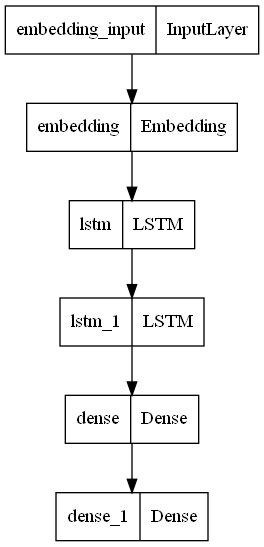

In [13]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [ ]:
### from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words_v2.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=70, batch_size=64, callbacks=[checkpoint])

In [14]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break                                                                                                                                                                   
  
  print(predicted_word)
  return predicted_word

In [ ]:
while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
        
      except Exception as e:
        print("Error occurred: ",e)
        continue


Enter your line: Neural networks have in recent years been applied quite successfully to a range condition
['a', 'range', 'condition']
monitoring
Enter your line: They are also very good for checking completeness of the
['completeness', 'of', 'the']
knowledge
